# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
# run this once to unzip the file
# !unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    # TODO: edit this function by appening transforms to the below list
    transforms = [        
        Resize(size), 
        ToTensor(),
        Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

processed_celeba_small/celeba/164896.jpg


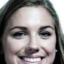

In [5]:
import glob
files = glob.glob(f"{data_dir}/*.jpg")
file_path = files[4] 
print(file_path)
Image.open(file_path)

In [6]:
from torchvision.io import read_image

class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        # TODO: implement the init method
        self.file_paths = glob.glob(f"{data_dir}/*{extension}")
        self.transforms = transforms        

    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        # TODO: return the number of elements in the dataset
        return len(self.file_paths)

    def __getitem__(self, idx: int) -> torch.Tensor:
        """ load an image and apply transformation """
        # TODO: return the index-element of the dataset data_dir        
        #img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img_path = self.file_paths[idx]
        image = Image.open(img_path)
        if self.transforms:
            image = self.transforms(image)        
        return image

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

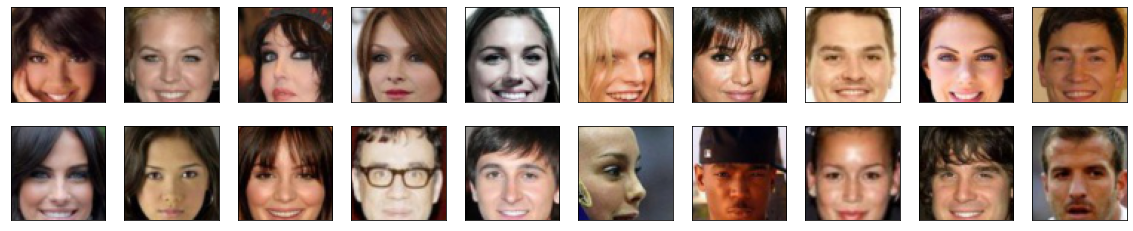

In [8]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [9]:
from torch import nn
from torch.nn import Module

In [10]:
class ConvBlock(Module):
    """
    A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, batch_norm: bool = True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2, padding=1, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [11]:
class Discriminator(Module):
    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        # 64x64 input
        self.conv1 = ConvBlock(3, conv_dim, 4, batch_norm=False) # first layer, no batch_norm
        # 32x32 out
        self.conv2 = ConvBlock(conv_dim, conv_dim*2, 4)
        # 16x16 out
        self.conv3 = ConvBlock(conv_dim*2, conv_dim*4, 4)
        # 8x8 out
        self.conv4 = ConvBlock(conv_dim*4, conv_dim*8, 4)
        # 4x4 out
        
        self.flatten = nn.Flatten()
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*2*4*4*4, 1)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # all hidden layers + leaky relu activation
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # flatten
        x = self.flatten(x)        
        # final output layer
        x = self.fc(x)
        # x = x.view([1, 1, 1, 1]) # To pass the test
        return x

In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
# tests.check_discriminator(discriminator)

### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [13]:
class DeconvBlock(nn.Module):
    """
    A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
    args:
    - in_channels: number of channels in the input to the conv layer
    - out_channels: number of filters in the conv layer
    - kernel_size: filter dimension of the conv layer
    - stride: stride of the conv layer
    - padding: padding of the conv layer
    - batch_norm: whether to use batch norm or not
    """
    def __init__(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 batch_norm: bool = True):
        super(DeconvBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.batch_norm = batch_norm
        if self.batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.deconv(x)
        if self.batch_norm:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [14]:
class Generator(Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 32):
        super(Generator, self).__init__()
        ####
        # IMPLEMENT HERE
        ####
        first_conv_dim = conv_dim // 8  # Because we have 3 conv layers that duplicate size (2^3 == 8)
        self.fc1 = nn.Linear(latent_dim, 512 * first_conv_dim ** 2) # 512*4*4
        self.unflatten = nn.Unflatten(1, (512, first_conv_dim, first_conv_dim) )  # 512x4x4, prepare shape for tconv
        # padding=1 to exactly duplicate sizes
        self.tconv_block1 = DeconvBlock(512, 256, kernel_size=4, stride=2, padding=1) # Out: 256x8x8
        self.tconv_block2 = DeconvBlock(256, 128, kernel_size=4, stride=2, padding=1) # Out: 128*16*16
        self.tconv_block3 = DeconvBlock(128, 64, kernel_size=4, stride=2, padding=1) # Out: 64*32*32
        self.tconv_4 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1) # Out: 3x64x64
        self.final_activation = nn.Tanh()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: implement the forward method
        x = x.squeeze()          # size [16, 128]
        x = self.fc1(x)          # size [16, 8192] (8192 == 512*4*4)
        x = self.unflatten(x)    # size [16, 512, 4, 4]
        x = self.tconv_block1(x) # size [16, 256, 8, 8]
        x = self.tconv_block2(x) # size [16, 128, 16, 16]
        x = self.tconv_block3(x) # size [16, 128, 16, 16]
        x = self.tconv_4(x)      # size [16, 3, 32, 32]
        x = self.final_activation(x)
        return x

In [15]:
def check_generator16(generator: torch.nn.Module, latent_dim: int):
    latent_vector = torch.randn(16, latent_dim, 1, 1)
    image = generator(latent_vector)
    assert image.shape == torch.Size([16, 3, 64, 64]), 'The generator should output a 64x64x3 images.'
    print('Congrats, your generator implementation passed all the tests')

In [16]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
# tests.check_generator(generator, latent_dim)
check_generator16(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [17]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    # TODO: implement the generator and discriminator optimizers
    # params (got values from paper)
    lr = 0.0002 
    beta1 = 0.5
    beta2 = 0.999

    # Create optimizers for the discriminator and generator
    d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
    g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])
    return g_optimizer, d_optimizer

## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [18]:
train_on_gpu = True

In [19]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [21]:
#def generator_loss(fake_logits):
#    """ Generator loss, takes the fake scores as inputs. """
#    # TODO: implement the generator loss 
#    
#    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [22]:
# def discriminator_loss(real_logits, fake_logits):
#     """ Discriminator loss, takes the fake and real logits as inputs. """
#    # TODO: implement the discriminator loss 
#    return loss

### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [23]:
# def gradient_penalty(discriminator, real_samples, fake_samples):
#    """ This function enforces """
#    gp = 0
#    # TODO (Optional): implement the gradient penalty
#    return gp

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [24]:
import torch.distributions.uniform as u

def get_random_latent_batch(batch_size, z_size):
    z = u.Uniform(-1, 1).sample((batch_size, z_size, 1, 1)) # Added 1,1 dimensions (compared to exercise part 1)    
    # z = scale(torch.randn(batch_size, z_size, 1, 1))  # Changed from Exercise part 1, added dimensions
    return z.cuda()

In [25]:
def generator_step(batch_size: int, latent_dim: int) -> Dict:
    """ One training step of the generator. """
    # TODO: implement the generator step (foward pass, loss calculation and backward pass)
    # =========================================
    #            TRAIN THE GENERATOR
    # =========================================
    g_optimizer.zero_grad()

    # 1. Generate random fake images        
    z = get_random_latent_batch(batch_size, z_size)
    fake_imgs = G(z)

    #2. Compute the discriminator loss on fake images using flipped labels
    d_fake_out = D(fake_imgs) # Detach got from solution video
    g_loss = real_loss(d_fake_out) # real loss to flip label

    # 3. Perform backpropagation + optim step to update weights
    g_loss.backward()
    g_optimizer.step()
    
    return {'loss': g_loss}


def discriminator_step(batch_size: int, latent_dim: int, real_images: torch.Tensor) -> Dict:
    """ One training step of the discriminator. """
    # TODO: implement the discriminator step (foward pass, loss calculation and backward pass)
    # ============================================
    #            TRAIN THE DISCRIMINATOR
    # ============================================
    d_optimizer.zero_grad()
    # 1. Compute discriminator loss on real, training images
    d_real_out = D(real_images)
    d_real_loss = real_loss(d_real_out, True)
    # 2. Generate random fake images
    # gradients don't have to flow
    with torch.no_grad():
        z = get_random_latent_batch(batch_size, z_size)  
        fake_imgs = G(z)

    # 3. Compute the discriminator loss on fake, generated images
    d_fake_out = D(fake_imgs.detach()) # Detach got from solution video
    d_fake_loss = fake_loss(d_fake_out)

    # 4. Add up real and fake loss
    d_loss = d_real_loss + d_fake_loss

    #5. Perform backpropagation + an optim step to update weights
    d_loss.backward()
    d_optimizer.step()
    
    gp = 0
    return {'loss': d_loss, 'gp': gp}

### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [26]:
from datetime import datetime

In [27]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

z_size = latent_dim

In [28]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
G = Generator(latent_dim).to(device)
D = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [29]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-08-07 00:31:23 | Epoch [1/20] | Batch 0/509 | d_loss: 1.3322 | g_loss: 1.1259
2023-08-07 00:31:28 | Epoch [1/20] | Batch 50/509 | d_loss: 0.3800 | g_loss: 5.5443
2023-08-07 00:31:33 | Epoch [1/20] | Batch 100/509 | d_loss: 0.3857 | g_loss: 5.0282
2023-08-07 00:31:38 | Epoch [1/20] | Batch 150/509 | d_loss: 1.6121 | g_loss: 3.7550
2023-08-07 00:31:42 | Epoch [1/20] | Batch 200/509 | d_loss: 0.9770 | g_loss: 1.4004
2023-08-07 00:31:47 | Epoch [1/20] | Batch 250/509 | d_loss: 0.6383 | g_loss: 2.7120
2023-08-07 00:31:52 | Epoch [1/20] | Batch 300/509 | d_loss: 0.7855 | g_loss: 2.8145
2023-08-07 00:31:57 | Epoch [1/20] | Batch 350/509 | d_loss: 0.7642 | g_loss: 2.2385
2023-08-07 00:32:02 | Epoch [1/20] | Batch 400/509 | d_loss: 0.7141 | g_loss: 2.3615
2023-08-07 00:32:07 | Epoch [1/20] | Batch 450/509 | d_loss: 1.5833 | g_loss: 3.5505
2023-08-07 00:32:11 | Epoch [1/20] | Batch 500/509 | d_loss: 0.7067 | g_loss: 2.0857


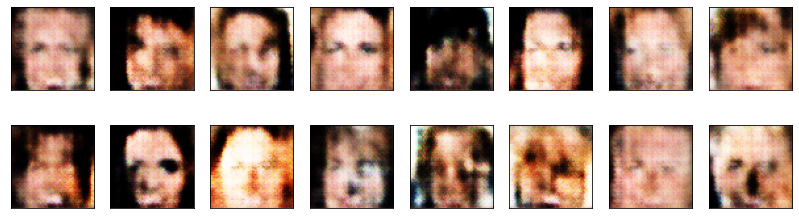

2023-08-07 00:32:17 | Epoch [2/20] | Batch 0/509 | d_loss: 0.7124 | g_loss: 2.3552
2023-08-07 00:32:21 | Epoch [2/20] | Batch 50/509 | d_loss: 1.1063 | g_loss: 5.7308
2023-08-07 00:32:26 | Epoch [2/20] | Batch 100/509 | d_loss: 0.7010 | g_loss: 3.1858
2023-08-07 00:32:31 | Epoch [2/20] | Batch 150/509 | d_loss: 0.5904 | g_loss: 3.6463
2023-08-07 00:32:35 | Epoch [2/20] | Batch 200/509 | d_loss: 0.9457 | g_loss: 2.7542
2023-08-07 00:32:40 | Epoch [2/20] | Batch 250/509 | d_loss: 1.0133 | g_loss: 3.3169
2023-08-07 00:32:45 | Epoch [2/20] | Batch 300/509 | d_loss: 0.6780 | g_loss: 2.0482
2023-08-07 00:32:49 | Epoch [2/20] | Batch 350/509 | d_loss: 0.8773 | g_loss: 1.6475
2023-08-07 00:32:54 | Epoch [2/20] | Batch 400/509 | d_loss: 1.4071 | g_loss: 3.7109
2023-08-07 00:32:59 | Epoch [2/20] | Batch 450/509 | d_loss: 0.7651 | g_loss: 2.9901
2023-08-07 00:33:03 | Epoch [2/20] | Batch 500/509 | d_loss: 0.6694 | g_loss: 1.6861


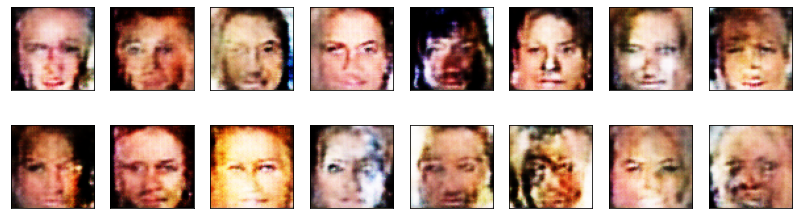

2023-08-07 00:33:07 | Epoch [3/20] | Batch 0/509 | d_loss: 0.8526 | g_loss: 1.8985
2023-08-07 00:33:12 | Epoch [3/20] | Batch 50/509 | d_loss: 0.9560 | g_loss: 2.5009
2023-08-07 00:33:16 | Epoch [3/20] | Batch 100/509 | d_loss: 0.7927 | g_loss: 1.8247
2023-08-07 00:33:21 | Epoch [3/20] | Batch 150/509 | d_loss: 0.9960 | g_loss: 2.6596
2023-08-07 00:33:26 | Epoch [3/20] | Batch 200/509 | d_loss: 1.1695 | g_loss: 2.2091
2023-08-07 00:33:30 | Epoch [3/20] | Batch 250/509 | d_loss: 0.5556 | g_loss: 2.5753
2023-08-07 00:33:35 | Epoch [3/20] | Batch 300/509 | d_loss: 0.7896 | g_loss: 2.4091
2023-08-07 00:33:39 | Epoch [3/20] | Batch 350/509 | d_loss: 0.8490 | g_loss: 1.4666
2023-08-07 00:33:44 | Epoch [3/20] | Batch 400/509 | d_loss: 0.8633 | g_loss: 1.3876
2023-08-07 00:33:49 | Epoch [3/20] | Batch 450/509 | d_loss: 0.8477 | g_loss: 3.1528
2023-08-07 00:33:53 | Epoch [3/20] | Batch 500/509 | d_loss: 0.7930 | g_loss: 1.8775


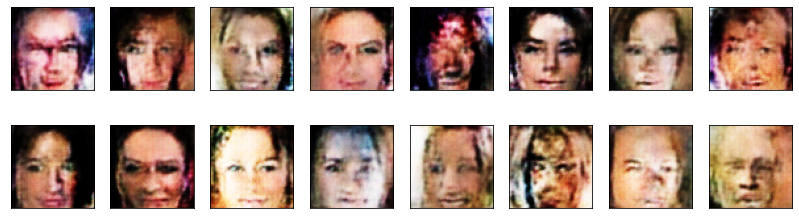

2023-08-07 00:33:59 | Epoch [4/20] | Batch 0/509 | d_loss: 0.7449 | g_loss: 1.6353
2023-08-07 00:34:04 | Epoch [4/20] | Batch 50/509 | d_loss: 0.6149 | g_loss: 2.8175
2023-08-07 00:34:08 | Epoch [4/20] | Batch 100/509 | d_loss: 0.6725 | g_loss: 1.9696
2023-08-07 00:34:13 | Epoch [4/20] | Batch 150/509 | d_loss: 0.7548 | g_loss: 1.8690
2023-08-07 00:34:17 | Epoch [4/20] | Batch 200/509 | d_loss: 0.6994 | g_loss: 2.6962
2023-08-07 00:34:22 | Epoch [4/20] | Batch 250/509 | d_loss: 0.7780 | g_loss: 2.3525
2023-08-07 00:34:27 | Epoch [4/20] | Batch 300/509 | d_loss: 0.8649 | g_loss: 1.6265
2023-08-07 00:34:31 | Epoch [4/20] | Batch 350/509 | d_loss: 0.8526 | g_loss: 1.7030
2023-08-07 00:34:36 | Epoch [4/20] | Batch 400/509 | d_loss: 0.5625 | g_loss: 2.5733
2023-08-07 00:34:41 | Epoch [4/20] | Batch 450/509 | d_loss: 0.8802 | g_loss: 1.8804
2023-08-07 00:34:45 | Epoch [4/20] | Batch 500/509 | d_loss: 0.9569 | g_loss: 2.0623


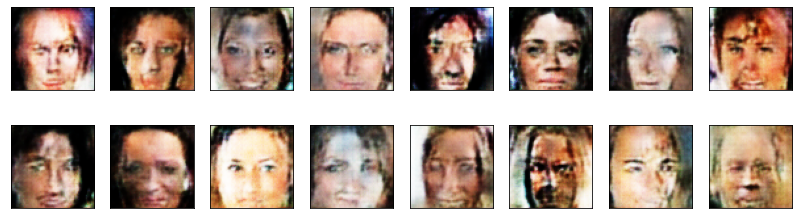

2023-08-07 00:34:50 | Epoch [5/20] | Batch 0/509 | d_loss: 0.6481 | g_loss: 3.0748
2023-08-07 00:34:55 | Epoch [5/20] | Batch 50/509 | d_loss: 0.6715 | g_loss: 1.8044
2023-08-07 00:34:59 | Epoch [5/20] | Batch 100/509 | d_loss: 0.6495 | g_loss: 1.9832
2023-08-07 00:35:04 | Epoch [5/20] | Batch 150/509 | d_loss: 0.9036 | g_loss: 1.7774
2023-08-07 00:35:08 | Epoch [5/20] | Batch 200/509 | d_loss: 0.6207 | g_loss: 2.6466
2023-08-07 00:35:13 | Epoch [5/20] | Batch 250/509 | d_loss: 0.6964 | g_loss: 2.3832
2023-08-07 00:35:18 | Epoch [5/20] | Batch 300/509 | d_loss: 0.3906 | g_loss: 3.8558
2023-08-07 00:35:23 | Epoch [5/20] | Batch 350/509 | d_loss: 0.8350 | g_loss: 3.1521
2023-08-07 00:35:28 | Epoch [5/20] | Batch 400/509 | d_loss: 0.4093 | g_loss: 2.6354
2023-08-07 00:35:32 | Epoch [5/20] | Batch 450/509 | d_loss: 0.7706 | g_loss: 3.7845
2023-08-07 00:35:37 | Epoch [5/20] | Batch 500/509 | d_loss: 0.6680 | g_loss: 2.1796


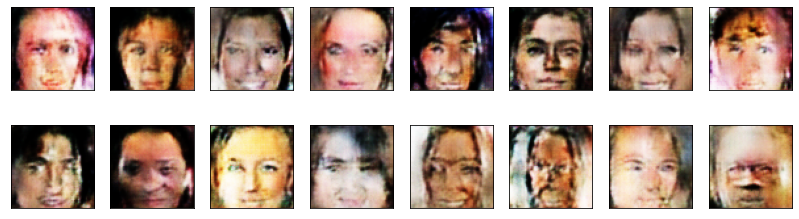

2023-08-07 00:35:42 | Epoch [6/20] | Batch 0/509 | d_loss: 0.4603 | g_loss: 3.4940
2023-08-07 00:35:47 | Epoch [6/20] | Batch 50/509 | d_loss: 0.6915 | g_loss: 2.6274
2023-08-07 00:35:52 | Epoch [6/20] | Batch 100/509 | d_loss: 0.4373 | g_loss: 2.8418
2023-08-07 00:35:57 | Epoch [6/20] | Batch 150/509 | d_loss: 0.5791 | g_loss: 2.9416
2023-08-07 00:36:01 | Epoch [6/20] | Batch 200/509 | d_loss: 0.4480 | g_loss: 2.2089
2023-08-07 00:36:06 | Epoch [6/20] | Batch 250/509 | d_loss: 0.3821 | g_loss: 2.7023
2023-08-07 00:36:10 | Epoch [6/20] | Batch 300/509 | d_loss: 0.6778 | g_loss: 4.2755
2023-08-07 00:36:15 | Epoch [6/20] | Batch 350/509 | d_loss: 0.4356 | g_loss: 4.4522
2023-08-07 00:36:20 | Epoch [6/20] | Batch 400/509 | d_loss: 0.4741 | g_loss: 4.3598
2023-08-07 00:36:24 | Epoch [6/20] | Batch 450/509 | d_loss: 0.4986 | g_loss: 4.6492
2023-08-07 00:36:29 | Epoch [6/20] | Batch 500/509 | d_loss: 0.5718 | g_loss: 3.7836


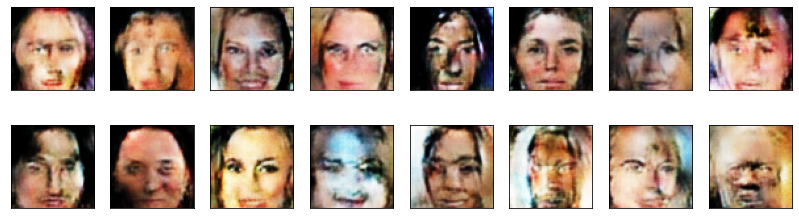

2023-08-07 00:36:34 | Epoch [7/20] | Batch 0/509 | d_loss: 0.7156 | g_loss: 3.5241
2023-08-07 00:36:38 | Epoch [7/20] | Batch 50/509 | d_loss: 0.6715 | g_loss: 3.4932
2023-08-07 00:36:43 | Epoch [7/20] | Batch 100/509 | d_loss: 0.6253 | g_loss: 4.3277
2023-08-07 00:36:48 | Epoch [7/20] | Batch 150/509 | d_loss: 0.5090 | g_loss: 3.4202
2023-08-07 00:36:52 | Epoch [7/20] | Batch 200/509 | d_loss: 0.4162 | g_loss: 2.7978
2023-08-07 00:36:57 | Epoch [7/20] | Batch 250/509 | d_loss: 0.5527 | g_loss: 1.8891
2023-08-07 00:37:01 | Epoch [7/20] | Batch 300/509 | d_loss: 1.0525 | g_loss: 5.9284
2023-08-07 00:37:06 | Epoch [7/20] | Batch 350/509 | d_loss: 1.8747 | g_loss: 6.5110
2023-08-07 00:37:11 | Epoch [7/20] | Batch 400/509 | d_loss: 0.8257 | g_loss: 5.3199
2023-08-07 00:37:15 | Epoch [7/20] | Batch 450/509 | d_loss: 0.5839 | g_loss: 4.9822
2023-08-07 00:37:20 | Epoch [7/20] | Batch 500/509 | d_loss: 0.4431 | g_loss: 2.5240


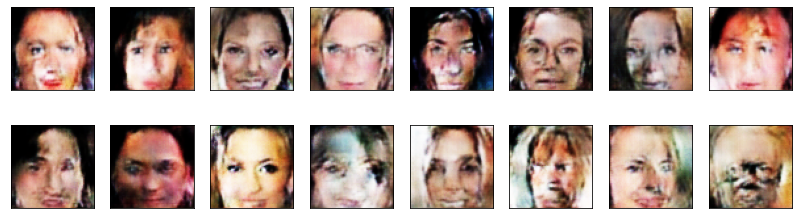

2023-08-07 00:37:25 | Epoch [8/20] | Batch 0/509 | d_loss: 0.4968 | g_loss: 2.3041
2023-08-07 00:37:30 | Epoch [8/20] | Batch 50/509 | d_loss: 0.8842 | g_loss: 2.4474
2023-08-07 00:37:34 | Epoch [8/20] | Batch 100/509 | d_loss: 0.3816 | g_loss: 4.3878
2023-08-07 00:37:39 | Epoch [8/20] | Batch 150/509 | d_loss: 0.3795 | g_loss: 3.8982
2023-08-07 00:37:44 | Epoch [8/20] | Batch 200/509 | d_loss: 0.6367 | g_loss: 5.6658
2023-08-07 00:37:49 | Epoch [8/20] | Batch 250/509 | d_loss: 0.3690 | g_loss: 4.8842
2023-08-07 00:37:53 | Epoch [8/20] | Batch 300/509 | d_loss: 0.6488 | g_loss: 2.8976
2023-08-07 00:37:58 | Epoch [8/20] | Batch 350/509 | d_loss: 0.5486 | g_loss: 3.7602
2023-08-07 00:38:02 | Epoch [8/20] | Batch 400/509 | d_loss: 0.3866 | g_loss: 3.9864
2023-08-07 00:38:07 | Epoch [8/20] | Batch 450/509 | d_loss: 0.5168 | g_loss: 4.9401
2023-08-07 00:38:12 | Epoch [8/20] | Batch 500/509 | d_loss: 0.4640 | g_loss: 3.2433


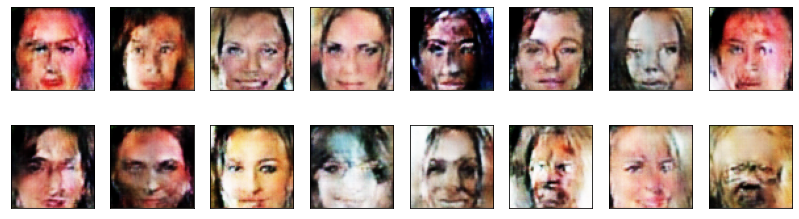

2023-08-07 00:38:16 | Epoch [9/20] | Batch 0/509 | d_loss: 0.3753 | g_loss: 3.3199
2023-08-07 00:38:21 | Epoch [9/20] | Batch 50/509 | d_loss: 0.5666 | g_loss: 4.4811
2023-08-07 00:38:26 | Epoch [9/20] | Batch 100/509 | d_loss: 0.9541 | g_loss: 3.4120
2023-08-07 00:38:30 | Epoch [9/20] | Batch 150/509 | d_loss: 0.5071 | g_loss: 4.1053
2023-08-07 00:38:35 | Epoch [9/20] | Batch 200/509 | d_loss: 0.4003 | g_loss: 2.4533
2023-08-07 00:38:40 | Epoch [9/20] | Batch 250/509 | d_loss: 0.4360 | g_loss: 2.3641
2023-08-07 00:38:44 | Epoch [9/20] | Batch 300/509 | d_loss: 0.3762 | g_loss: 3.1729
2023-08-07 00:38:49 | Epoch [9/20] | Batch 350/509 | d_loss: 0.4233 | g_loss: 2.9604
2023-08-07 00:38:53 | Epoch [9/20] | Batch 400/509 | d_loss: 0.6408 | g_loss: 4.1772
2023-08-07 00:38:58 | Epoch [9/20] | Batch 450/509 | d_loss: 0.3775 | g_loss: 4.2275
2023-08-07 00:39:03 | Epoch [9/20] | Batch 500/509 | d_loss: 0.5808 | g_loss: 4.3294


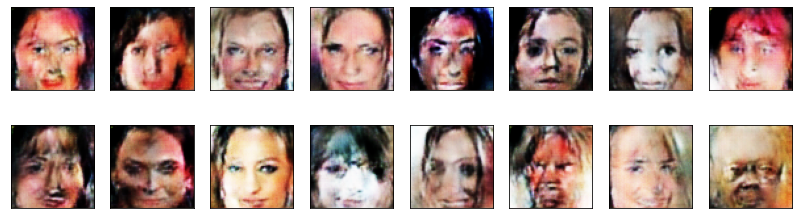

2023-08-07 00:39:09 | Epoch [10/20] | Batch 0/509 | d_loss: 0.4211 | g_loss: 3.2467
2023-08-07 00:39:14 | Epoch [10/20] | Batch 50/509 | d_loss: 0.3903 | g_loss: 3.1859
2023-08-07 00:39:18 | Epoch [10/20] | Batch 100/509 | d_loss: 0.6754 | g_loss: 5.2108
2023-08-07 00:39:23 | Epoch [10/20] | Batch 150/509 | d_loss: 0.5253 | g_loss: 3.9514
2023-08-07 00:39:28 | Epoch [10/20] | Batch 200/509 | d_loss: 0.3782 | g_loss: 3.8017
2023-08-07 00:39:32 | Epoch [10/20] | Batch 250/509 | d_loss: 0.4082 | g_loss: 3.5501
2023-08-07 00:39:37 | Epoch [10/20] | Batch 300/509 | d_loss: 0.3970 | g_loss: 4.3920
2023-08-07 00:39:42 | Epoch [10/20] | Batch 350/509 | d_loss: 0.3677 | g_loss: 4.0857
2023-08-07 00:39:46 | Epoch [10/20] | Batch 400/509 | d_loss: 0.3864 | g_loss: 3.0517
2023-08-07 00:39:51 | Epoch [10/20] | Batch 450/509 | d_loss: 0.3618 | g_loss: 4.0639
2023-08-07 00:39:56 | Epoch [10/20] | Batch 500/509 | d_loss: 0.4831 | g_loss: 4.6251


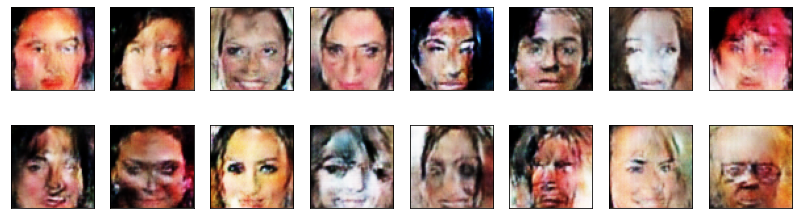

2023-08-07 00:40:01 | Epoch [11/20] | Batch 0/509 | d_loss: 0.5012 | g_loss: 4.7334
2023-08-07 00:40:06 | Epoch [11/20] | Batch 50/509 | d_loss: 0.5426 | g_loss: 5.0847
2023-08-07 00:40:11 | Epoch [11/20] | Batch 100/509 | d_loss: 0.4499 | g_loss: 3.6011
2023-08-07 00:40:15 | Epoch [11/20] | Batch 150/509 | d_loss: 0.4624 | g_loss: 4.9908
2023-08-07 00:40:20 | Epoch [11/20] | Batch 200/509 | d_loss: 0.3834 | g_loss: 4.1655
2023-08-07 00:40:25 | Epoch [11/20] | Batch 250/509 | d_loss: 0.4471 | g_loss: 3.8635
2023-08-07 00:40:29 | Epoch [11/20] | Batch 300/509 | d_loss: 0.5049 | g_loss: 2.6161
2023-08-07 00:40:34 | Epoch [11/20] | Batch 350/509 | d_loss: 0.4510 | g_loss: 4.5879
2023-08-07 00:40:39 | Epoch [11/20] | Batch 400/509 | d_loss: 0.3648 | g_loss: 5.0785
2023-08-07 00:40:43 | Epoch [11/20] | Batch 450/509 | d_loss: 0.4269 | g_loss: 4.1616
2023-08-07 00:40:48 | Epoch [11/20] | Batch 500/509 | d_loss: 0.5458 | g_loss: 5.1738


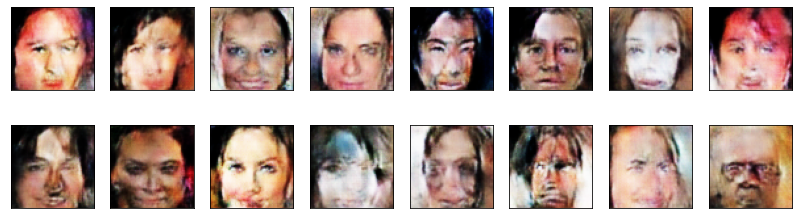

2023-08-07 00:40:52 | Epoch [12/20] | Batch 0/509 | d_loss: 0.3710 | g_loss: 3.8121
2023-08-07 00:40:57 | Epoch [12/20] | Batch 50/509 | d_loss: 1.0096 | g_loss: 3.1663
2023-08-07 00:41:02 | Epoch [12/20] | Batch 100/509 | d_loss: 0.6526 | g_loss: 2.2798
2023-08-07 00:41:06 | Epoch [12/20] | Batch 150/509 | d_loss: 0.4033 | g_loss: 3.6465
2023-08-07 00:41:11 | Epoch [12/20] | Batch 200/509 | d_loss: 0.4646 | g_loss: 3.2628
2023-08-07 00:41:16 | Epoch [12/20] | Batch 250/509 | d_loss: 0.4902 | g_loss: 2.4051
2023-08-07 00:41:20 | Epoch [12/20] | Batch 300/509 | d_loss: 0.4889 | g_loss: 2.8473
2023-08-07 00:41:25 | Epoch [12/20] | Batch 350/509 | d_loss: 0.3997 | g_loss: 3.7269
2023-08-07 00:41:30 | Epoch [12/20] | Batch 400/509 | d_loss: 0.3690 | g_loss: 5.0349
2023-08-07 00:41:34 | Epoch [12/20] | Batch 450/509 | d_loss: 0.4028 | g_loss: 3.8950
2023-08-07 00:41:39 | Epoch [12/20] | Batch 500/509 | d_loss: 0.5002 | g_loss: 4.2374


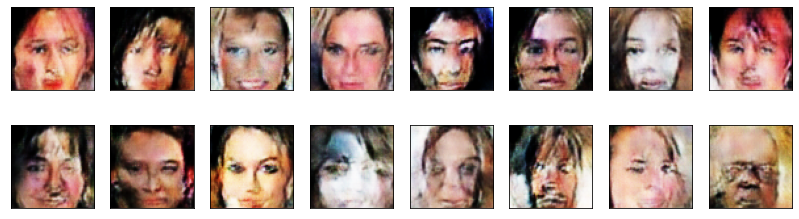

2023-08-07 00:41:43 | Epoch [13/20] | Batch 0/509 | d_loss: 0.3545 | g_loss: 5.6321
2023-08-07 00:41:48 | Epoch [13/20] | Batch 50/509 | d_loss: 0.3713 | g_loss: 5.1941
2023-08-07 00:41:53 | Epoch [13/20] | Batch 100/509 | d_loss: 0.7601 | g_loss: 3.8248
2023-08-07 00:41:57 | Epoch [13/20] | Batch 150/509 | d_loss: 0.3829 | g_loss: 4.2507
2023-08-07 00:42:02 | Epoch [13/20] | Batch 200/509 | d_loss: 0.3537 | g_loss: 6.3839
2023-08-07 00:42:07 | Epoch [13/20] | Batch 250/509 | d_loss: 0.7939 | g_loss: 2.8506
2023-08-07 00:42:11 | Epoch [13/20] | Batch 300/509 | d_loss: 0.4731 | g_loss: 2.2608
2023-08-07 00:42:16 | Epoch [13/20] | Batch 350/509 | d_loss: 0.4228 | g_loss: 3.5544
2023-08-07 00:42:21 | Epoch [13/20] | Batch 400/509 | d_loss: 0.3954 | g_loss: 3.1303
2023-08-07 00:42:25 | Epoch [13/20] | Batch 450/509 | d_loss: 0.4526 | g_loss: 4.8823
2023-08-07 00:42:30 | Epoch [13/20] | Batch 500/509 | d_loss: 0.3828 | g_loss: 5.1596


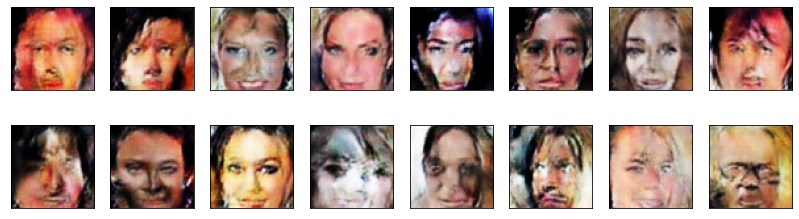

2023-08-07 00:42:34 | Epoch [14/20] | Batch 0/509 | d_loss: 0.3619 | g_loss: 4.7041
2023-08-07 00:42:39 | Epoch [14/20] | Batch 50/509 | d_loss: 0.4043 | g_loss: 4.1185
2023-08-07 00:42:44 | Epoch [14/20] | Batch 100/509 | d_loss: 0.3964 | g_loss: 3.6674
2023-08-07 00:42:48 | Epoch [14/20] | Batch 150/509 | d_loss: 0.5774 | g_loss: 5.9721
2023-08-07 00:42:53 | Epoch [14/20] | Batch 200/509 | d_loss: 3.0605 | g_loss: 6.8989
2023-08-07 00:42:58 | Epoch [14/20] | Batch 250/509 | d_loss: 0.4510 | g_loss: 4.5307
2023-08-07 00:43:02 | Epoch [14/20] | Batch 300/509 | d_loss: 0.8686 | g_loss: 2.7251
2023-08-07 00:43:07 | Epoch [14/20] | Batch 350/509 | d_loss: 0.6900 | g_loss: 4.1518
2023-08-07 00:43:11 | Epoch [14/20] | Batch 400/509 | d_loss: 0.6179 | g_loss: 1.7461
2023-08-07 00:43:16 | Epoch [14/20] | Batch 450/509 | d_loss: 0.3850 | g_loss: 6.1206
2023-08-07 00:43:21 | Epoch [14/20] | Batch 500/509 | d_loss: 0.4167 | g_loss: 3.0761


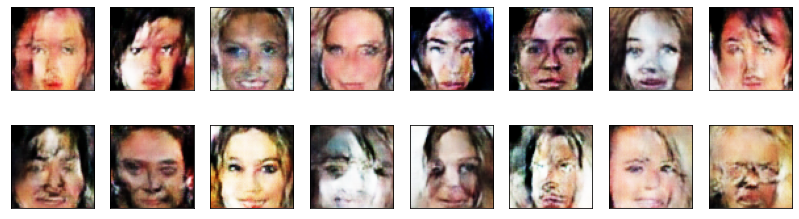

2023-08-07 00:43:25 | Epoch [15/20] | Batch 0/509 | d_loss: 0.4328 | g_loss: 5.2313
2023-08-07 00:43:30 | Epoch [15/20] | Batch 50/509 | d_loss: 0.4408 | g_loss: 4.0636
2023-08-07 00:43:35 | Epoch [15/20] | Batch 100/509 | d_loss: 0.6151 | g_loss: 4.4868
2023-08-07 00:43:39 | Epoch [15/20] | Batch 150/509 | d_loss: 0.6760 | g_loss: 3.4467
2023-08-07 00:43:44 | Epoch [15/20] | Batch 200/509 | d_loss: 0.4092 | g_loss: 3.3959
2023-08-07 00:43:48 | Epoch [15/20] | Batch 250/509 | d_loss: 0.3925 | g_loss: 3.2024
2023-08-07 00:43:53 | Epoch [15/20] | Batch 300/509 | d_loss: 0.4051 | g_loss: 4.9099
2023-08-07 00:43:58 | Epoch [15/20] | Batch 350/509 | d_loss: 0.4074 | g_loss: 3.3508
2023-08-07 00:44:03 | Epoch [15/20] | Batch 400/509 | d_loss: 0.4101 | g_loss: 5.4563
2023-08-07 00:44:07 | Epoch [15/20] | Batch 450/509 | d_loss: 0.4446 | g_loss: 5.0148
2023-08-07 00:44:12 | Epoch [15/20] | Batch 500/509 | d_loss: 0.3926 | g_loss: 3.4314


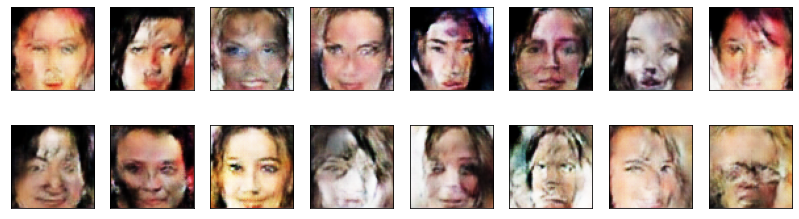

2023-08-07 00:44:17 | Epoch [16/20] | Batch 0/509 | d_loss: 0.5095 | g_loss: 4.4062
2023-08-07 00:44:21 | Epoch [16/20] | Batch 50/509 | d_loss: 0.3874 | g_loss: 4.3349
2023-08-07 00:44:26 | Epoch [16/20] | Batch 100/509 | d_loss: 0.3749 | g_loss: 3.5657
2023-08-07 00:44:31 | Epoch [16/20] | Batch 150/509 | d_loss: 0.5937 | g_loss: 2.2051
2023-08-07 00:44:35 | Epoch [16/20] | Batch 200/509 | d_loss: 0.5049 | g_loss: 3.9706
2023-08-07 00:44:40 | Epoch [16/20] | Batch 250/509 | d_loss: 0.4184 | g_loss: 3.6713
2023-08-07 00:44:44 | Epoch [16/20] | Batch 300/509 | d_loss: 0.3887 | g_loss: 3.8246
2023-08-07 00:44:49 | Epoch [16/20] | Batch 350/509 | d_loss: 0.3716 | g_loss: 3.2440
2023-08-07 00:44:54 | Epoch [16/20] | Batch 400/509 | d_loss: 0.4000 | g_loss: 1.9261
2023-08-07 00:44:58 | Epoch [16/20] | Batch 450/509 | d_loss: 0.3904 | g_loss: 3.9752
2023-08-07 00:45:03 | Epoch [16/20] | Batch 500/509 | d_loss: 0.4031 | g_loss: 4.2928


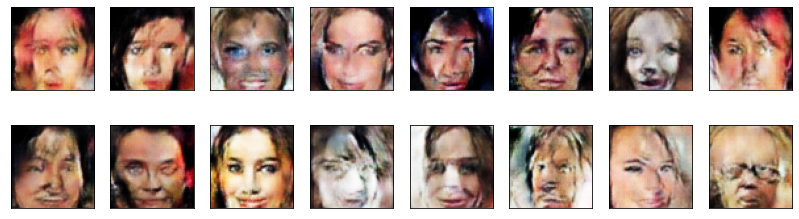

2023-08-07 00:45:08 | Epoch [17/20] | Batch 0/509 | d_loss: 0.3600 | g_loss: 5.0691
2023-08-07 00:45:13 | Epoch [17/20] | Batch 50/509 | d_loss: 0.3657 | g_loss: 7.0300
2023-08-07 00:45:18 | Epoch [17/20] | Batch 100/509 | d_loss: 1.6526 | g_loss: 2.7706
2023-08-07 00:45:22 | Epoch [17/20] | Batch 150/509 | d_loss: 0.5057 | g_loss: 4.8069
2023-08-07 00:45:27 | Epoch [17/20] | Batch 200/509 | d_loss: 0.5519 | g_loss: 2.8845
2023-08-07 00:45:31 | Epoch [17/20] | Batch 250/509 | d_loss: 0.4680 | g_loss: 3.2513
2023-08-07 00:45:36 | Epoch [17/20] | Batch 300/509 | d_loss: 0.3771 | g_loss: 3.4590
2023-08-07 00:45:41 | Epoch [17/20] | Batch 350/509 | d_loss: 0.3942 | g_loss: 3.0362
2023-08-07 00:45:45 | Epoch [17/20] | Batch 400/509 | d_loss: 0.6974 | g_loss: 1.9727
2023-08-07 00:45:50 | Epoch [17/20] | Batch 450/509 | d_loss: 0.3450 | g_loss: 4.3294
2023-08-07 00:45:55 | Epoch [17/20] | Batch 500/509 | d_loss: 0.4215 | g_loss: 2.3744


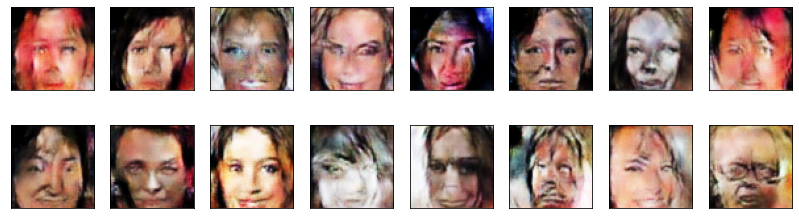

2023-08-07 00:46:01 | Epoch [18/20] | Batch 0/509 | d_loss: 0.3965 | g_loss: 4.1854
2023-08-07 00:46:05 | Epoch [18/20] | Batch 50/509 | d_loss: 0.4166 | g_loss: 3.3994
2023-08-07 00:46:10 | Epoch [18/20] | Batch 100/509 | d_loss: 0.3711 | g_loss: 2.9102
2023-08-07 00:46:14 | Epoch [18/20] | Batch 150/509 | d_loss: 0.3989 | g_loss: 3.9683
2023-08-07 00:46:18 | Epoch [18/20] | Batch 200/509 | d_loss: 0.4769 | g_loss: 4.3947
2023-08-07 00:46:23 | Epoch [18/20] | Batch 250/509 | d_loss: 0.4355 | g_loss: 4.4025
2023-08-07 00:46:27 | Epoch [18/20] | Batch 300/509 | d_loss: 0.3607 | g_loss: 6.1869
2023-08-07 00:46:32 | Epoch [18/20] | Batch 350/509 | d_loss: 0.3458 | g_loss: 7.1411
2023-08-07 00:46:36 | Epoch [18/20] | Batch 400/509 | d_loss: 0.3652 | g_loss: 3.9111
2023-08-07 00:46:41 | Epoch [18/20] | Batch 450/509 | d_loss: 1.8623 | g_loss: 10.3067
2023-08-07 00:46:46 | Epoch [18/20] | Batch 500/509 | d_loss: 0.4194 | g_loss: 2.8679


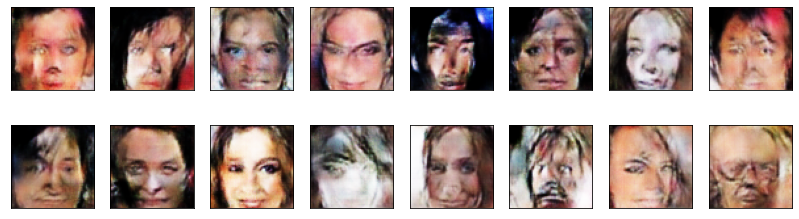

2023-08-07 00:46:50 | Epoch [19/20] | Batch 0/509 | d_loss: 0.3957 | g_loss: 4.3994
2023-08-07 00:46:55 | Epoch [19/20] | Batch 50/509 | d_loss: 1.2472 | g_loss: 6.6392
2023-08-07 00:46:59 | Epoch [19/20] | Batch 100/509 | d_loss: 0.3861 | g_loss: 4.5085
2023-08-07 00:47:04 | Epoch [19/20] | Batch 150/509 | d_loss: 0.3847 | g_loss: 4.0885
2023-08-07 00:47:08 | Epoch [19/20] | Batch 200/509 | d_loss: 0.3987 | g_loss: 4.6056
2023-08-07 00:47:13 | Epoch [19/20] | Batch 250/509 | d_loss: 0.4127 | g_loss: 4.7671
2023-08-07 00:47:17 | Epoch [19/20] | Batch 300/509 | d_loss: 0.4706 | g_loss: 2.9170
2023-08-07 00:47:22 | Epoch [19/20] | Batch 350/509 | d_loss: 0.5110 | g_loss: 4.3672
2023-08-07 00:47:26 | Epoch [19/20] | Batch 400/509 | d_loss: 0.3782 | g_loss: 4.6539
2023-08-07 00:47:31 | Epoch [19/20] | Batch 450/509 | d_loss: 0.3957 | g_loss: 5.7548
2023-08-07 00:47:35 | Epoch [19/20] | Batch 500/509 | d_loss: 0.4172 | g_loss: 4.8763


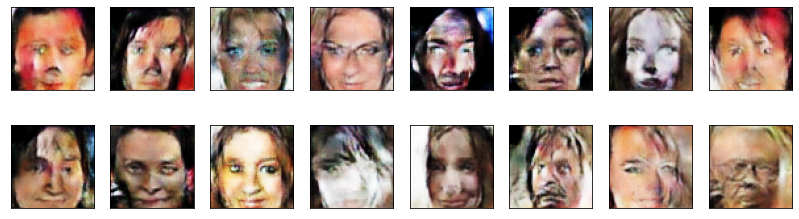

2023-08-07 00:47:40 | Epoch [20/20] | Batch 0/509 | d_loss: 0.3505 | g_loss: 6.4573
2023-08-07 00:47:44 | Epoch [20/20] | Batch 50/509 | d_loss: 0.3886 | g_loss: 2.7862
2023-08-07 00:47:49 | Epoch [20/20] | Batch 100/509 | d_loss: 0.6880 | g_loss: 5.5325
2023-08-07 00:47:54 | Epoch [20/20] | Batch 150/509 | d_loss: 0.4677 | g_loss: 3.3104
2023-08-07 00:47:58 | Epoch [20/20] | Batch 200/509 | d_loss: 0.5919 | g_loss: 1.8603
2023-08-07 00:48:02 | Epoch [20/20] | Batch 250/509 | d_loss: 0.4157 | g_loss: 3.5818
2023-08-07 00:48:07 | Epoch [20/20] | Batch 300/509 | d_loss: 0.3899 | g_loss: 2.6471
2023-08-07 00:48:12 | Epoch [20/20] | Batch 350/509 | d_loss: 0.4227 | g_loss: 3.6989
2023-08-07 00:48:16 | Epoch [20/20] | Batch 400/509 | d_loss: 0.4066 | g_loss: 2.7018
2023-08-07 00:48:20 | Epoch [20/20] | Batch 450/509 | d_loss: 0.4641 | g_loss: 3.9131
2023-08-07 00:48:25 | Epoch [20/20] | Batch 500/509 | d_loss: 0.3587 | g_loss: 5.9735


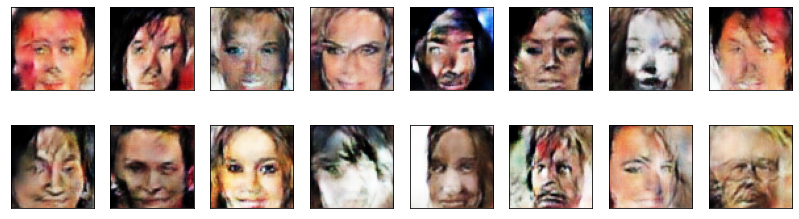

In [30]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().cuda()

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        ####################################
        
        # TODO: implement the training strategy
        
        ####################################
        d_loss = discriminator_step(batch_size, latent_dim, real_images)
        g_loss = generator_step(batch_size, latent_dim)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss'].item()
            g = g_loss['loss'].item()
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    G.eval()
    generated_images = G(fixed_latent_vector)
    display(generated_images)
    G.train()

### Training losses

Plot the training losses for the generator and discriminator.

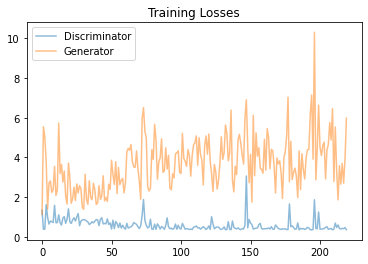

In [31]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** Although these look like faces, they are clearly different from the input ones. We could build deeper generator and discriminator networks (more layers). Also to include gradient penalty and play with the hyperparams.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.